### Recruitment Scam

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification
# from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
import re
from string import punctuation
import datetime
import time
import random

import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\q1htx\anaconda3\envs\recruitment-scams-final-venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

if torch.cuda.is_available():
    device = torch.device("cuda")
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device:{cuda_id}")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

2.6.0+cu118
ID of current CUDA device:0
There are 1 GPU(s) available.
Name of current CUDA device: NVIDIA GeForce RTX 4090 Laptop GPU


In [3]:
df = pd.read_csv('dataset/DataSet.csv')
df_original = df.copy()
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17880 non-null  object
 6   requirements         15191 non-null  object
 7   benefits             10684 non-null  object
 8   telecommuting        17880 non-null  object
 9   has_company_logo     17880 non-null  object
 10  has_questions        17880 non-null  object
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [5]:
df.describe()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
count,17880,17534,6333,2868,14572,17880,15191,10684,17880,17880,17880,14409,10830,9775,12977,11425,17880,17880
unique,11231,3105,1337,874,1710,15095,12119,6510,2,2,2,5,7,13,131,37,2,2
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,<p>We help teachers get safe &amp; secure jobs...,"<p>Play with kids, get paid for it </p>\r\n<p>...",<p>University degree required. TEFL / TESOL / ...,<p>See job description</p>,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,f,f
freq,311,718,551,142,726,376,410,726,17113,14220,9088,11620,3809,5145,1734,1749,17014,16980


A fraudulent job posting can be identified based on:

- Structured Tabular Data: Binary features (telecommuting, has_company_logo, has_questions), categorical features (location, department, employment_type, required_experience, required_education, industry, function).
- Textual Data: description, requirements, company_profile, benefits
- Salary Information: Extracted and processed from salary_range.
- Feature Interactions: Fraudulent postings often show unique feature interactions across modalities.

### EDA
To better understand data relationship with each other and `fraudulent`, perform uni, bi, multivariate analysis on numerical, categorical and binary features.

In [6]:
binary_features = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
df[binary_features] = df[binary_features].replace({'f': 0, 't': 1})
df[binary_features] = df[binary_features].astype(int)
df.head()

C:\Users\q1htx\AppData\Local\Temp\ipykernel_14188\3823665431.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_features] = df[binary_features].replace({'f': 0, 't': 1})


,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,f


In [7]:
df_salary = df.copy()

df_salary[['min_salary', 'max_salary']] = df_salary['salary_range'].str.split('-', expand=True)
df_salary['min_salary'] = pd.to_numeric(df_salary['min_salary'], errors='coerce')
df_salary['max_salary'] = pd.to_numeric(df_salary['max_salary'], errors='coerce')

df_salary['salary_avg'] = df_salary[['min_salary', 'max_salary']].mean(axis=1)
df_salary['salary_avg'].describe().astype(int)

count          2868
mean         657836
std        22268016
min               0
25%           21750
50%           44000
75%           72500
max      1000000000
Name: salary_avg, dtype: int64

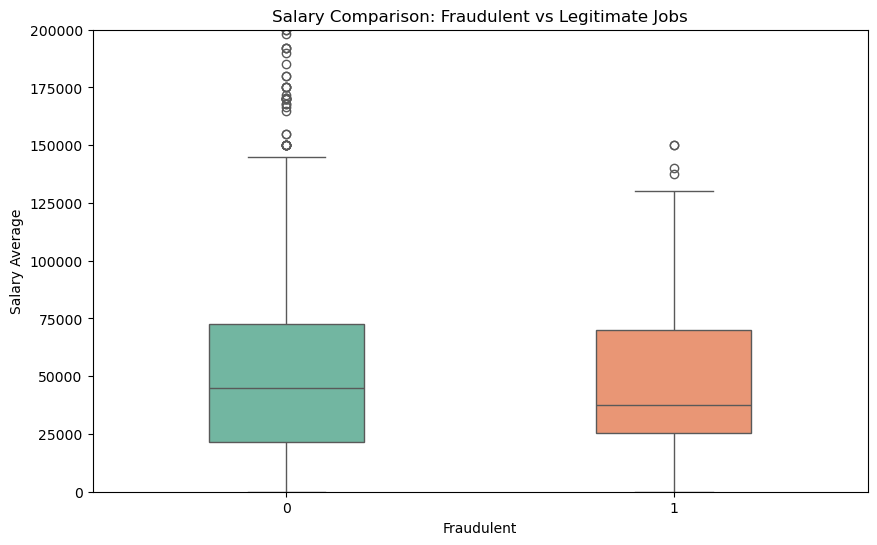

In [8]:
df_salary_cleaned = df_salary.dropna(subset=['salary_avg'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='fraudulent', y='salary_avg', data=df_salary_cleaned, width=0.4, palette='Set2', hue='fraudulent', legend=False)
plt.title('Salary Comparison: Fraudulent vs Legitimate Jobs')
plt.xlabel('Fraudulent')
plt.ylabel('Salary Average')

plt.ylim(0, 200000)  # adjust upper limit
plt.show()

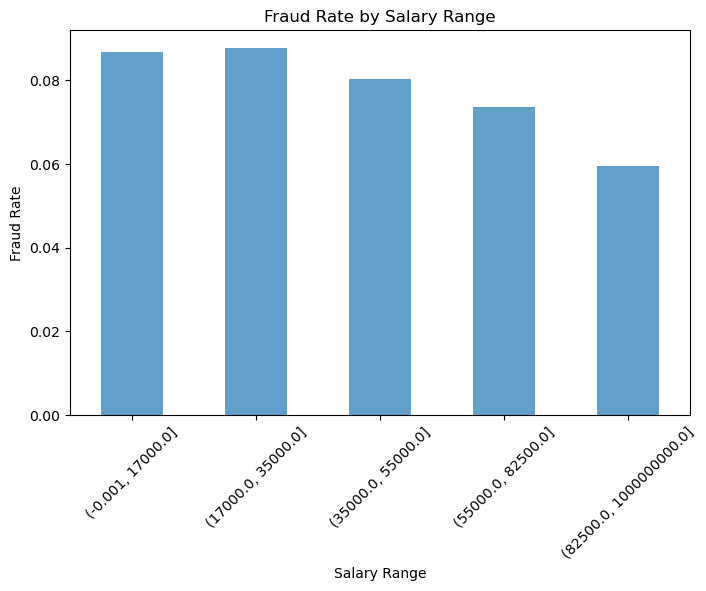

In [9]:
salary_bins = pd.qcut(df_salary_cleaned['salary_avg'], q=5)  # Bin salary into quantiles
fraud_rate = df_salary_cleaned.groupby(salary_bins, observed=False)['fraudulent'].mean()

plt.figure(figsize=(8,5))
fraud_rate.plot(kind='bar', alpha=0.7)
plt.xlabel("Salary Range")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Salary Range")
plt.xticks(rotation=45)
plt.show()

While there are observable differences in salary distributions, there is significant overlap in salary ranges between fraudulent and legitimate jobs as observed in the box plot, and fraudulent rate is more or less even across the different salary ranges, suggesting that that salary alone is not a definitive indicator of job legitimacy. Move on to analyse other features.

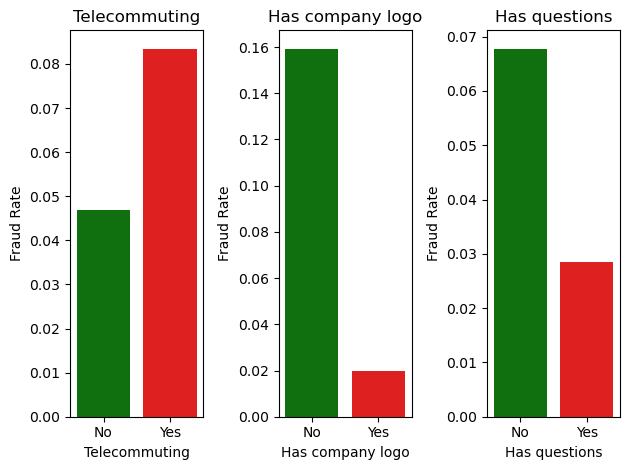

In [10]:
binary_features = ['telecommuting', 'has_company_logo', 'has_questions']

for i, feature in enumerate(binary_features, 1):
    plt.subplot(1, 3, i)
    fraud_rate = df.groupby(feature)["fraudulent"].mean()
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values, palette=["green", "red"], hue=fraud_rate.index, legend=False)
    plt.xticks([0, 1], labels=["No", "Yes"])
    plt.ylabel("Fraud Rate")
    plt.xlabel(feature.replace("_", " ").capitalize())
    plt.title(f"{feature.replace('_', ' ').capitalize()}")

plt.tight_layout()
plt.show()

The observation above suggests that telecommuting jobs, job postings without company logo have a higher risk of being fraudulent, possibly since scammers might use the allure of remote work to attract more applicants and lack the proper verified company logo. It can be used as a good indicator of fraud detection.

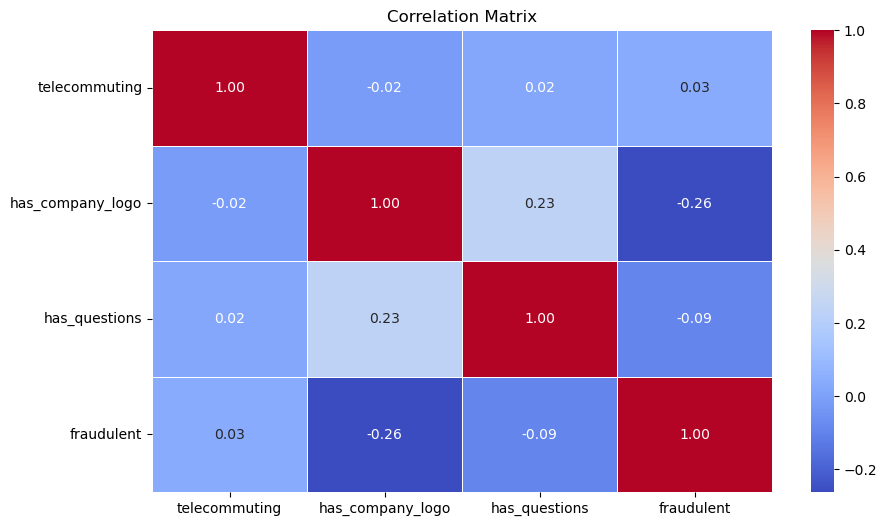

In [11]:
numerical_data = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

corr_matrix = df[numerical_data].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The -0.26 correlation between `has_company_logo` and `fraudulent` suggests a moderate tendency for job postings with company logos to be less likely to be fraudulent.

##### Use pairwise Chi-square tests to derive how categorical features interact with fraudulent:

In [12]:
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function'] # 'location', 'department' have too many unique values
chi_square_results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['fraudulent'])
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
    
    chi_square_results.append([feature, chi2_stat, p_val, "Significant" if p_val < 0.05 else "Not Significant"])

chi_results_df = pd.DataFrame(chi_square_results, columns=["Feature", "Chi-Square Statistic", "P-Value", "Conclusion"])
chi_results_df

,Feature,Chi-Square Statistic,P-Value,Conclusion
0,employment_type,65.111518,2.437701e-13,Significant
1,required_experience,99.141369,3.790204e-19,Significant
2,required_education,506.859232,7.684948e-101,Significant
3,industry,1712.034406,7.008397e-274,Significant
4,function,567.386057,9.284874e-97,Significant


The strongest association are with `required_education` and `industry`, as these have the highest chi-square statistics and the smallest p-values. Further examine the relationship with `fraudulent`.

Text(0.5, 1.0, 'Fraud Job Distribution by Employment Type')

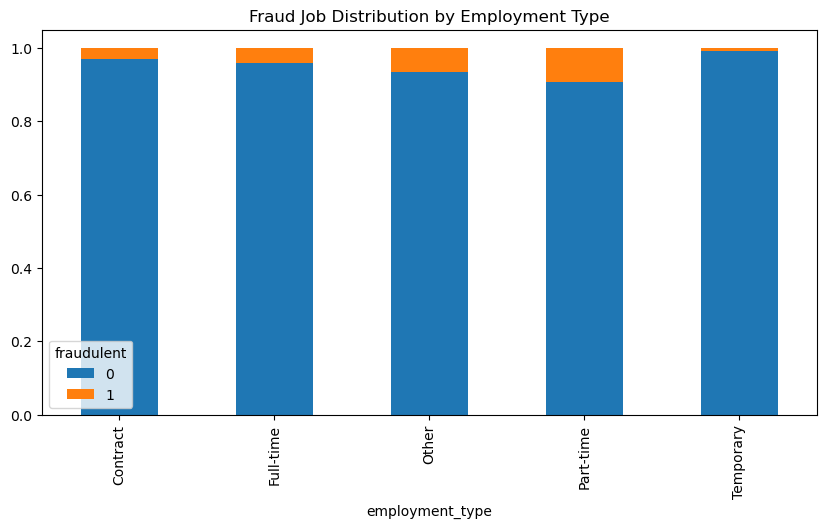

In [13]:
fraud_by_type = df.groupby("employment_type")["fraudulent"].value_counts(normalize=True).unstack()
fraud_by_type.plot(kind='bar', figsize=(10, 5), stacked=True)
plt.title("Fraud Job Distribution by Employment Type")

Entry-Level Positions have noticeable fraudulent cases, suggesting that scammers may be targeting fresh graduates and job seekers with little experience, who may be more vulnerable to fraud. This aligns with the idea that fraudsters may prefer job types that offer less job security or verification.

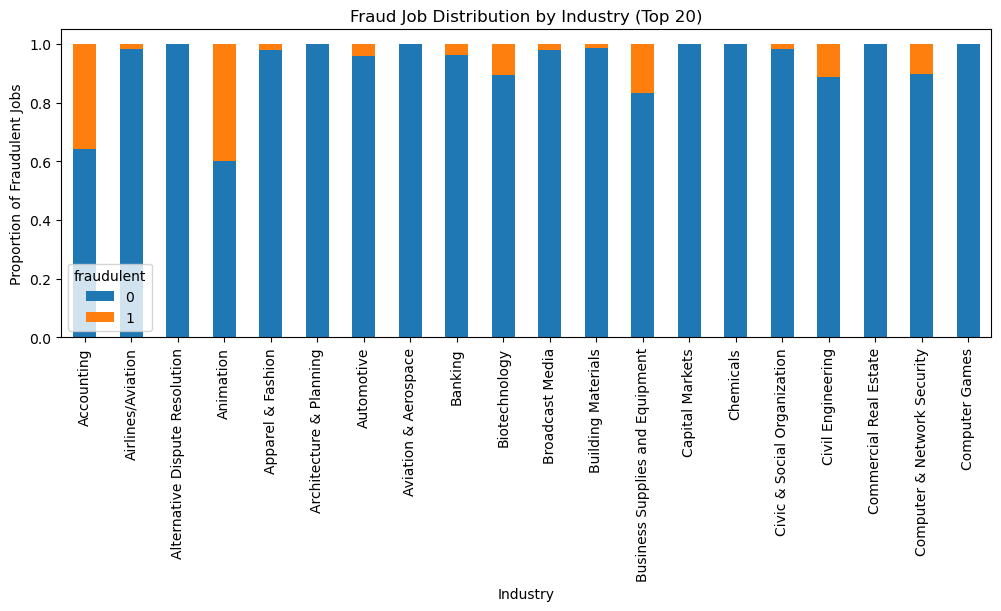

In [14]:
fraud_by_industry = df.groupby("industry")["fraudulent"].value_counts(normalize=True).unstack()
top_20_industries = fraud_by_industry.sum(axis=1).nlargest(20).index
fraud_by_industry_top20 = fraud_by_industry.loc[top_20_industries]

fraud_by_industry_top20.plot(kind='bar', figsize=(12, 4), stacked=True)
plt.title("Fraud Job Distribution by Industry (Top 20)")
plt.xlabel("Industry")
plt.ylabel("Proportion of Fraudulent Jobs")
plt.xticks(rotation=90)
plt.show()


As observed, the chart highlights that the likelihood of encountering a fraudulent job posting is not uniform across all industries, suggesting that industry-specific factors might contribute to fraud.

In [15]:
df.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                0
requirements            2689
benefits                7196
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
in_balanced_dataset        0
dtype: int64

Analyse the relationship between various features (numerical and categorical) and the likelihood of a job posting being fraudulent. Recruitment scams often exhibit patterns such as missing or incomplete values in certain fields, as scammers tend to create poorly constructed or incomplete job listings. 

<b> Test the hypothesis that missing values in specific columns are correlated with fraudulent job postings. </b>

Key features to examine include:
- Numerical features: salary range
- Categorical features: Location, department, employment type, required experience, required education, industry, and function.

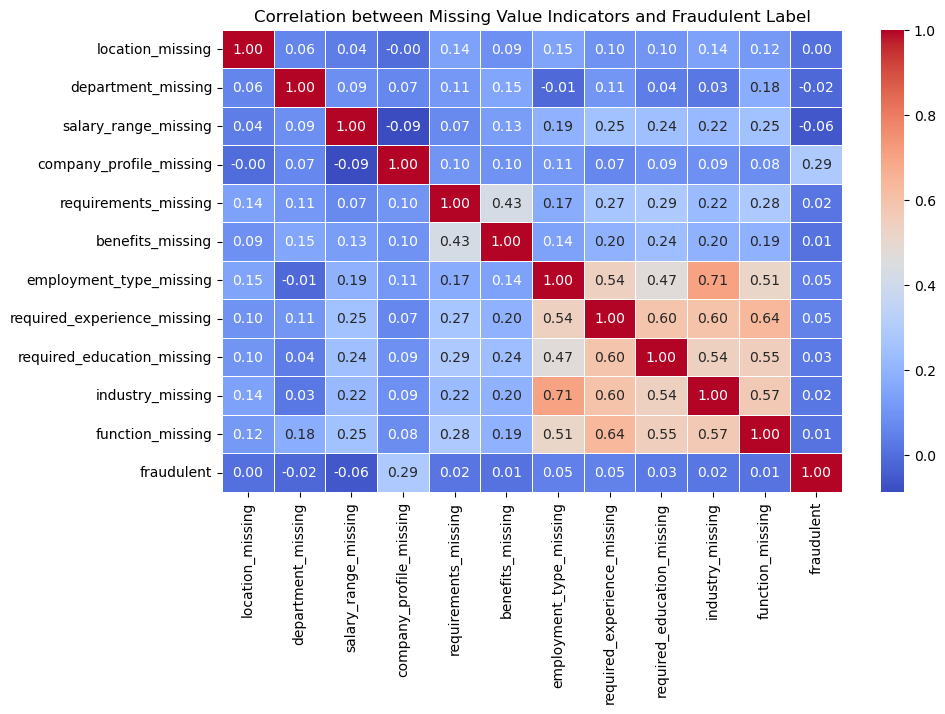

In [16]:
columns_with_missing_data = [
    'location', 'department', 'salary_range', 'company_profile',
    'requirements', 'benefits', 'employment_type', 'required_experience',
    'required_education', 'industry', 'function'
]

df_missing = df.copy()

for col in columns_with_missing_data:
    df_missing.loc[:, f'{col}_missing'] = df_missing[col].isnull().astype(int)

df_missing = df_missing.drop(columns=columns_with_missing_data)
df_missing.describe()
missing_cols = [f'{col}_missing' for col in columns_with_missing_data]
missing_correlation = df_missing[missing_cols + ['fraudulent']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation between Missing Value Indicators and Fraudulent Label')
plt.show()


Fraudulent job listings tend to have more missing data across multiple columns, suggesting that these poorly constructed postings lack key information. For instance, `employment_type_missing` often correlates with `industry_missing` (0.71) and `required_experience_missing` (0.54).

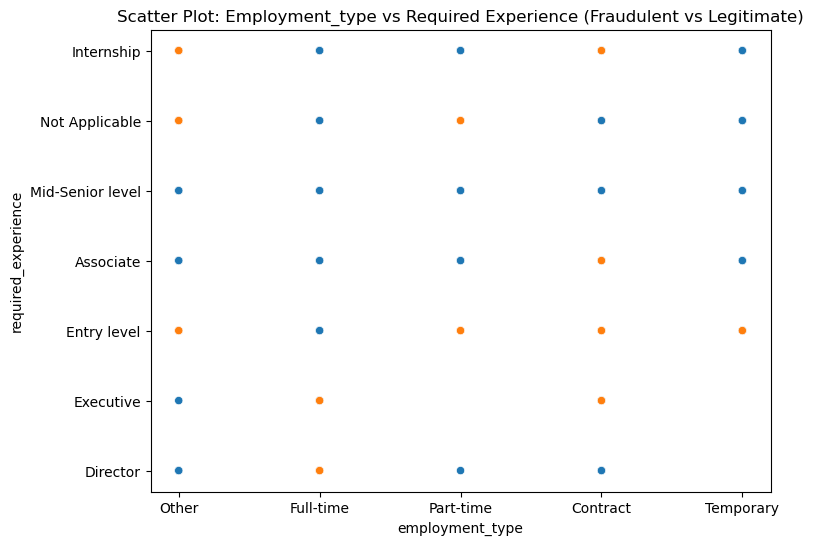

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='employment_type', y='required_experience', hue='fraudulent', data=df, legend=False)
plt.title('Scatter Plot: Employment_type vs Required Experience (Fraudulent vs Legitimate)')
plt.show()


In [18]:
# Find out where missing data is more prevalent in fraudulent job listings than non-fraudulent ones.

fraudulent_missing_data = df[columns_with_missing_data + ['fraudulent']].groupby('fraudulent').apply(lambda x: x.isnull().mean(), include_groups=False)
fraudulent_missing_data

,location,department,salary_range,company_profile,requirements,benefits,employment_type,required_experience,required_education,industry,function
fraudulent,,,,,,,,,,,
0,0.019219,0.647467,0.844540,0.159927,0.149054,0.401610,0.189844,0.388797,0.449865,0.272011,0.359586
1,0.021940,0.613164,0.742494,0.677829,0.176674,0.419169,0.278291,0.502309,0.520785,0.317552,0.389145


<b> Note </b>

From analysing numerical, binary features, and categorical features, we have determined that some features (telecommuting, has_company_logo, has_questions, employment_type, required_experience, required_education, industry) do have a strong relationship with fraudulent jobs.

Pivot to analyzing the textual content of the listings and its relationship with fraud to investigate for more robust indicators of fraudulent activity.

### Binary Classification Problem: Fraudulent vs. Non-Fraudulent Job Postings
Given a set of job postings and their description in text format, the goal is to train a model that can analyze the textual content and distinguish between fraudulent and legitimate postings based on patterns in language, structure, or common deceptive practices. RoBERTa (A Robustly Optimized BERT Pretraining Approach), a variant of BERT (Bidirectional Encoder Representations from Transformers), is able to perform sentiment analysis and classification effectively.

#### Text Pre-processing (NLP Features) and Feature Engineering
Text fields like `description`, `company_profile`, `requirements`, and `benefits` contain key fraud indicators.

- Text Cleaning: decontraction, removing characters, stopwords and tags
- Tokenization: Convert raw job postings into tokenized inputs using RoBERTa’s Byte-Pair Encoding.
- Truncation & Padding: Ensure all sequences have the same length
- Label Encoding: Convert class labels (fraudulent = 1, not fraudulent = 0) into numerical format.
- Balancing the dataset: Undersample the majority class (a moderately balanced dataset has a split of 2:1)
- Split dataset

In [19]:
def merge_text(df):
    text = ""
    features = ['title', 'location', 'department', 'company_profile', 'description', 
                'requirements', 'benefits', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']
    
    for feature in features:
        value = str(df[feature]) if pd.notna(df[feature]) else ""  # Handle NaN
        
        if value not in text:
            text += value + ' '

    return text.strip()

df_raw = df.copy()
df_raw['text'] = df_raw.apply(lambda x: merge_text(x), axis=1)

In [20]:
def decontraction(string):
    contractions = {
        "n't": " not",
        "'ve": " have",
        "'d've": 'would have',
        "'cause": "because",
        "'d": " would",
        "'ll": " will",
        "ma'am": 'madam',
        "'s": " is",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "'re": " are",
        "'ll've": 'will have',  
  }
    for key, value in contractions.items():
        string = string.replace(key, value)
    return string

def remove_char(string):
    characters = [u"\xa0", "http", "https", "://",".","•","‘","’", "-","–",
                  "\r","\n","|","/", "…","+",'`','"','\'',"“","”",","]
    for char in characters:
        string = string.replace(char,' ')

    string = re.sub(' +', ' ',string).strip()
    return string

def remove_tag(string):
    return re.sub(r'<.*?>', '', string)

stop_words = stopwords.words('english')
punc_list = list(punctuation)

def clean_and_tokenise(string):
    tokens = word_tokenize(string)
    # clean_tokens = [token for token in tokens if token not in stop_words and token not in punc_list]
    clean_tokens = [token for token in tokens if 'url_' not in token and 'email_' not in token]
    return ' '.join(clean_tokens)

In [21]:
df_text = df_raw[['text','fraudulent']].copy()

df_text["text"] = df_text["text"].str.lower()  
df_text["text"] = df_text["text"].apply(lambda x: remove_char(remove_tag(decontraction(x))))  
df_text["text"] = df_text["text"].apply(clean_and_tokenise)  

df_text.to_csv('text.csv',index=False)

df_text.head()

,text,fraudulent
0,marketing intern us ny new york we are food52 ...,0
1,customer service cloud video production nz auc...,0
2,commissioning machinery assistant ( cma ) us i...,0
3,account executive washington dc us dc washingt...,0
4,bill review manager us fl fort worth spotsourc...,0


In [22]:
# Balance the data 

df_0 = df_text[df_text['fraudulent']==0].sample(1500) # undersample the majority class
df_1 = df_text[df_text['fraudulent']==1]

df_balanced = pd.concat([df_0, df_1], axis=0).sample(frac=1, random_state=42) # shuffle all rows
print(f"df_balanced: {df_balanced['fraudulent'].value_counts()}") 

data_texts = df_balanced['text'].to_list()
data_labels = df_balanced['fraudulent'].to_list()


df_balanced: fraudulent
0    1500
1     866
Name: count, dtype: int64


In [23]:
# Split the balanced data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=42)

# Further split the training set into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

print(len(test_texts), len(test_labels))
print(len(train_texts), len(train_labels))
print(len(val_texts), len(val_labels))

474 474
1513 1513
379 379


In [24]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# train_encodings = tokenizer(train_texts, truncation = True, padding = True)
# val_encodings = tokenizer(val_texts, truncation = True, padding = True)

In [25]:
def map_token_to_id(texts, labels):
    input_ids = []
    attention_masks = []

    for sentence in texts:
        encoded_dict = tokenizer.encode_plus(
            sentence, # tokenise sentence            
            add_special_tokens = True, # Add '[CLS]' to start, and '[SEP]' to end
            max_length = 256,
            padding = 'max_length',
            truncation=True,
            return_attention_mask = True, # Construct attention masks.
            return_tensors = 'pt', # Return torch tensor
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = map_token_to_id(train_texts, train_labels)
val_input_ids, val_attention_masks, val_labels = map_token_to_id(val_texts, val_labels)
test_input_ids, test_attention_masks, test_labels = map_token_to_id(test_texts, test_labels)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


### Model Training
Fine-tune `RobertaForSequenceClassification` model on `train_dataset` to learn to better predict fraudulent job postings.

In [26]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', 
    num_labels = 2,   # binary classification
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [27]:
optimizer = AdamW(
  model.parameters(),
  lr = 2e-5, # args.learning_rate - default is 5e-5
  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
)

In [28]:
batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

test_dataloader = DataLoader(
    test_dataset, 
    sampler=SequentialSampler(test_dataset), 
    batch_size=32
)

In [29]:
epochs = 10
total_steps = len(train_dataloader) * epochs

learning_rate_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, # Default value in run_glue.py
    num_training_steps = total_steps
)

In [30]:
def train_loop(dataloader, model, optimizer):
    model.train()
    train_loss, train_correct, size= 0, 0, 0
    num_batches=len(dataloader)
    # size = len(dataloader.dataset)

    for batch in dataloader:
        # print("Number of elements in batch:", len(batch))
        # print("Batch size:", batch[0].shape[0])  
        
        input_ids, input_mask, labels = batch
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        labels = labels.to(device)

        # Forward Pass
        prediction = model(input_ids,
                           token_type_ids=None,
                           attention_mask=input_mask,
                           labels=labels,
                           return_dict=True)

        loss = prediction.loss
        logits= prediction.logits

        train_loss+=loss.item()
        train_correct+=(logits.argmax(1) == labels).type(torch.float).sum().item()
        size += labels.size(0) # Dynamic

        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        learning_rate_scheduler.step() # update learning rate

    train_loss /= num_batches
    train_correct /= size # normalize accuracy
    return train_loss, train_correct

def val_loop(dataloader, model):
    model.eval()
    num_batches=len(dataloader)
    val_loss, val_correct, size = 0, 0, 0 
    # size = len(dataloader.dataset)

    with torch.no_grad(): # disable gradient computation
        for batch in dataloader:
            input_ids, input_mask, labels = batch
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            labels = labels.to(device)
            
            prediction = model(input_ids,
                           token_type_ids=None,
                           attention_mask=input_mask,
                           labels=labels,
                           return_dict=True)
            loss = prediction.loss
            logits= prediction.logits

            val_loss+=loss.item()
            val_correct+=(logits.argmax(1) == labels).type(torch.float).sum().item()
            size+=labels.size(0)

    val_correct /= size # average val acc
    val_loss /= num_batches
    return val_loss, val_correct


# def test_loop(dataloader, model):
#     # Load the saved model
#     model.eval()
#     true_labels = []
#     test_correct = 0
#     size = 0

#     with torch.no_grad(): # disable gradient computation
#         for batch in dataloader:
#             input_ids, input_mask, labels = batch
#             input_ids = input_ids.to(device)
#             input_mask = input_mask.to(device)
#             labels = labels.to(device)
            
#             prediction = model(input_ids,
#                            token_type_ids=None,
#                            attention_mask=input_mask,
#                            return_dict=True)
#             logits= prediction.logits

#             test_correct+=(logits.argmax(1) == labels).type(torch.float).sum().item()
#             size+=labels.size(0)
#             true_labels.append(labels)

#     test_correct /= size
#     return test_correct, true_labels

In [31]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [32]:
train_loss_final, train_accuracy_final = [], []
val_loss_final, val_accuracy_final = [], []

best_val_accuracy = 0

for epoch in range(0, epochs):
    train_loss, train_accuracy = train_loop(train_dataloader, model, optimizer)
    val_loss, val_accuracy = val_loop(train_dataloader, model)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    train_loss_final.append(train_loss)
    train_accuracy_final.append(train_accuracy)
    val_loss_final.append(val_loss)
    val_accuracy_final.append(val_accuracy)

    print(f"Epoch {epoch}: Train Accuracy: {(100 * train_accuracy):.2f}, Val Accuracy: {(100 * val_accuracy):.2f}")

Epoch 0: Train Accuracy: 76.07, Val Accuracy: 84.40
Epoch 1: Train Accuracy: 90.81, Val Accuracy: 96.89
Epoch 2: Train Accuracy: 95.57, Val Accuracy: 96.70
Epoch 3: Train Accuracy: 97.88, Val Accuracy: 98.55
Epoch 4: Train Accuracy: 98.74, Val Accuracy: 99.60
Epoch 5: Train Accuracy: 99.27, Val Accuracy: 99.60
Epoch 6: Train Accuracy: 99.47, Val Accuracy: 99.87
Epoch 7: Train Accuracy: 99.87, Val Accuracy: 99.87
Epoch 8: Train Accuracy: 99.87, Val Accuracy: 99.93
Epoch 9: Train Accuracy: 99.93, Val Accuracy: 99.93


In [33]:
df = pd.DataFrame({
    "Epoch": range(1, epochs + 1),
    "Training Loss": train_loss_final,
    "Validation Loss": val_loss_final,
    "Validation Accuracy": val_accuracy_final
})

print(df.to_string(index=False))  # index=False removes the index column

 Epoch  Training Loss  Validation Loss  Validation Accuracy
     1       0.469980         0.380669             0.844019
     2       0.251514         0.108067             0.968936
     3       0.163245         0.106358             0.966953
     4       0.082373         0.063167             0.985459
     5       0.047675         0.021761             0.996034
     6       0.028045         0.014467             0.996034
     7       0.017626         0.004888             0.998678
     8       0.005182         0.002380             0.998678
     9       0.003577         0.001419             0.999339
    10       0.002092         0.000968             0.999339


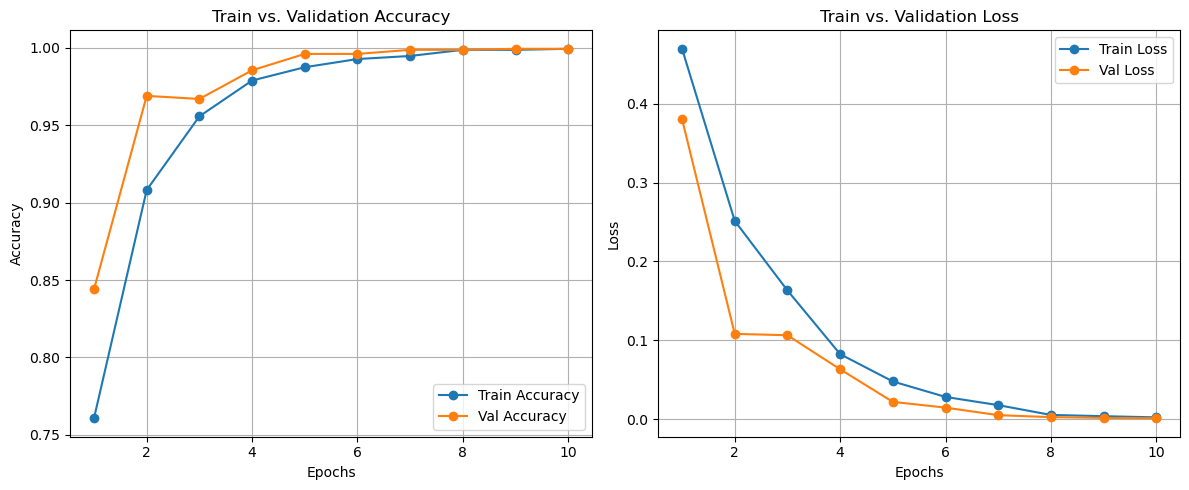

In [34]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracy_final, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs+1), val_accuracy_final, label="Val Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs. Validation Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_loss_final, label="Train Loss", marker='o')
plt.plot(range(1, epochs+1), val_loss_final, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

Evaluate on Test Set

In [35]:
def evaluate_model(test_dataloader, model):
    model.eval()
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, input_mask, labels = batch
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            labels = labels.to(device)

            prediction = model(input_ids, token_type_ids=None, attention_mask=input_mask, return_dict=True)
            logits = prediction.logits
            
            predictions.append(logits.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    # Combine across all batches
    total_predictions = np.concatenate(predictions, axis=0)
    total_true_labels = np.concatenate(true_labels, axis=0)
    total_predictions = np.argmax(total_predictions, axis=1).flatten()

    f1 = f1_score(total_true_labels, total_predictions)
    accuracy = accuracy_score(total_true_labels, total_predictions)
    print(f'F1 Score: {f1:.3f}\nAccuracy Score: {accuracy:.3f}\n')
    
    target_names = ['Non fraudulent', 'Fraudulent']
    print(classification_report(total_true_labels, total_predictions, target_names=target_names))
    return total_true_labels, total_predictions

total_true_labels, total_predictions = evaluate_model(test_dataloader, model)

F1 Score: 0.891
Accuracy Score: 0.924

                precision    recall  f1-score   support

Non fraudulent       0.95      0.94      0.94       311
    Fraudulent       0.88      0.90      0.89       163

      accuracy                           0.92       474
     macro avg       0.91      0.92      0.92       474
  weighted avg       0.92      0.92      0.92       474



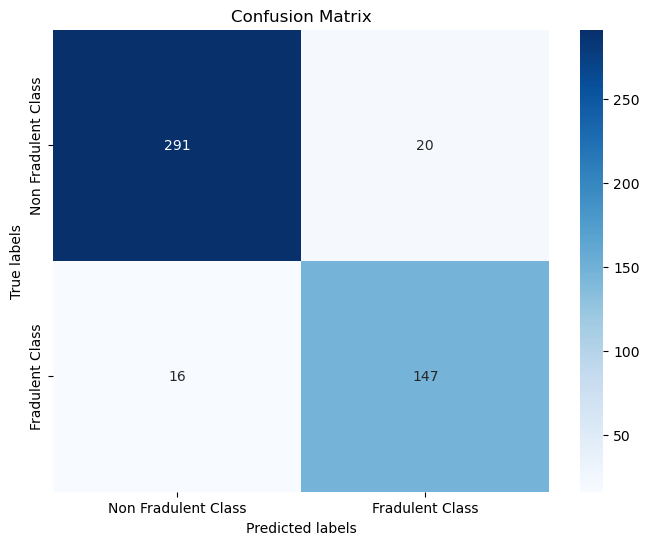

In [36]:
confusion_matrix_test = confusion_matrix(total_true_labels, total_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non Fradulent Class', 'Fradulent Class'],
            yticklabels=['Non Fradulent Class', 'Fradulent Class'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('heat_map.png')

plt.show()

#### Multi-modal Approach
Combines both the results from RoBERTa analysis (for text data) and other numerical, categorical, and binary features 

In [37]:
# # Get embeddings from text model

# # df_balanced
# data_texts = df_balanced['text'].to_list()
# data_labels = df_balanced['fraudulent'].to_list() 


In [38]:
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

# structural_data = df_original[['telecommuting', 'has_company_logo', 'has_questions', 'required_experience', 'required_education', 'employment_type', 'industry']]
# encoder = OneHotEncoder()
# structural_data_encoded = encoder.fit_transform(structural_data[['employment_type', 'industry']])

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df[['salary_range']])  # assuming salary is a numerical feature

# combined_features = np.hstack([embeddings, structural_data_encoded.toarray(), scaled_data])

In [39]:
# import xgboost as xgb

# X_train, X_test, y_train, y_test = train_test_split(combined_features, df['fraudulent'], test_size=0.2, random_state=42)

# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train)

# y_pred = xgb_model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')